In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
# from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f'TensorFlow Version: {tf.__version__}')

TensorFlow Version: 2.1.0


# Data preprocessing

## Data download

In [2]:
train_dir = './nature_scene/seg_train/seg_train'
validation_dir = './nature_scene/seg_test/seg_test/'
test_dir = './nature_scene/seg_pred/seg_pred/'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (192, 192)
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1. / 255)
# test_datagen = ImageDataGenerator(rescale=1. / 255)

In [4]:
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=IMG_SIZE)
val_dataset = validation_datagen.flow_from_directory(validation_dir,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=IMG_SIZE)
# test_dataset = test_datagen.flow_from_directory(test_dir,
#                                                 batch_size=BATCH_SIZE,
#                                                 target_size=IMG_SIZE)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


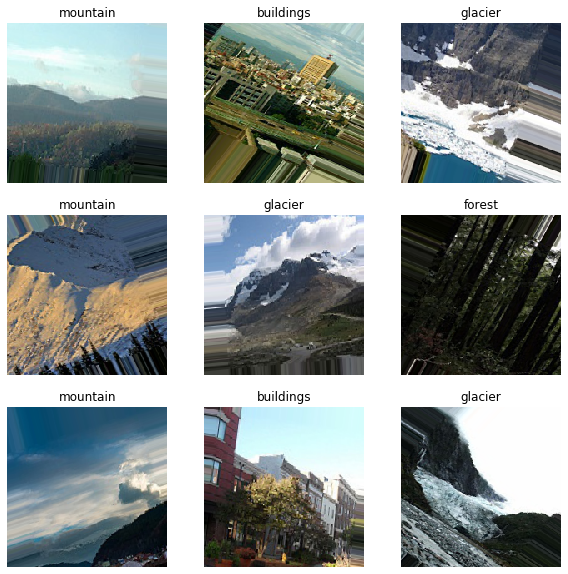

In [5]:
class_names = {v: k for k, v in train_dataset.class_indices.items()}

plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_dataset[0][0][i])
    plt.title(class_names[np.argmax(train_dataset[0][1][i])])
    plt.axis('off')

# Create the base model from the pretrained convnets

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(192, 192, 3)


In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Feature Extraction

## Freeze the convolutional base

In [9]:
base_model.trainable = False

## Important note about Batchnormlization layers
- 设置layer.trainable = False时，Batchnormalization会以推断模式运行，不会更改相应的均值方差
- 当你为了微调没有freeze带有batchnormalization层的模型时，调用该模型时应传入training=False使BN层以推断模式运行

## Build Model by keras function API

In [11]:
num_classes = len(class_names)
inputs = tf.keras.Input(shape=(192, 192, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


## Compile the model
- 标签有两个类别，损失函数使用二分交叉熵损失函数，model最后是线性输出，设置from_logit=True

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model 

In [15]:
# 查看模型初始精度
loss0, acc0 = model.evaluate(val_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

  ...
    to  
  ['...']
94/94 [==============================] - 32s 339ms/step - loss: 2.2009 - accuracy: 0.0870
initial loss: 2.20
initial accuracy: 0.09


In [16]:
initial_epochs = 10 
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 439 steps, validate for 94 steps
Epoch 1/10
439/439 [==============================] - 205s 468ms/step - loss: 1.2065 - accuracy: 0.5229 - val_loss: 0.6775 - val_accuracy: 0.7467
Epoch 2/10
439/439 [==============================] - 204s 465ms/step - loss: 0.6489 - accuracy: 0.7587 - val_loss: 0.4822 - val_accuracy: 0.8153
Epoch 3/10
439/439 [==============================] - 201s 459ms/step - loss: 0.5371 - accuracy: 0.8004 - val_loss: 0.4063 - val_accuracy: 0.8397
Epoch 4/10
439/439 [==============================] - 202s 461ms/step - loss: 0.4802 - accuracy: 0.8220 - val_loss: 0.3611 - val_accuracy: 0.8620
Epoch 5/10
439/439 [==============================] - 203s 462ms/step - loss: 0.4526 - accuracy: 0.8270 - val_loss: 0.3364 - val_accuracy: 0.8713
Epoch 6/10
439/439 [==============================] - 204s 464ms/step - loss: 0.4329 - accuracy: 0.8405 - val_loss: 0.3245 - val_accuracy: 0.8757
Epoch 7/10
439/439 [===========

## Learn crves
- Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

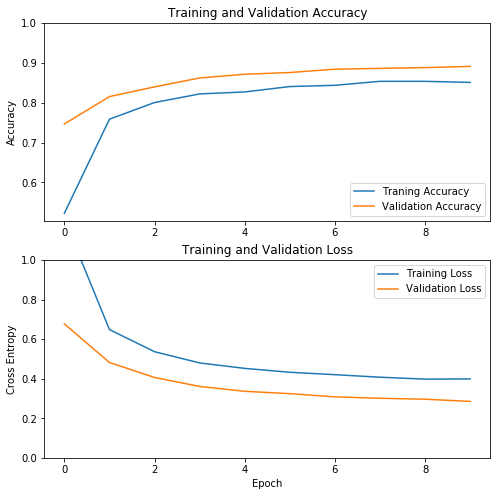

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Traning Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Fine Tune

## Un-freeze the top layers of the model

In [18]:
base_model.trainable = True
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 155


In [19]:
# fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 403,078
Trainable params: 7,686
Non-trainable params: 395,392
_________________________________________________________________


In [21]:
len(model.trainable_variables)

58

## Complie the model

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Continue training the model

In [23]:
fine_tune_epochs = 10 
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 439 steps, validate for 94 steps
Epoch 10/20
439/439 [==============================] - 311s 708ms/step - loss: 0.3704 - accuracy: 0.8627 - val_loss: 0.2638 - val_accuracy: 0.9000
Epoch 11/20
439/439 [==============================] - 304s 692ms/step - loss: 0.3190 - accuracy: 0.8833 - val_loss: 0.2430 - val_accuracy: 0.9077
Epoch 12/20
439/439 [==============================] - 306s 697ms/step - loss: 0.2945 - accuracy: 0.8911 - val_loss: 0.2509 - val_accuracy: 0.9023
Epoch 13/20
439/439 [==============================] - 299s 682ms/step - loss: 0.2805 - accuracy: 0.8984 - val_loss: 0.2393 - val_accuracy: 0.9107
Epoch 14/20
439/439 [==============================] - 338s 770ms/step - loss: 0.2664 - accuracy: 0.9040 - val_loss: 0.2356 - val_accuracy: 0.9097
Epoch 15/20
439/439 [==============================] - 325s 741ms/step - loss: 0.2501 - accuracy: 0.9109 - val_loss: 0.2137 - val_accuracy: 0.9137
Epoch 16/20
439/439 [====

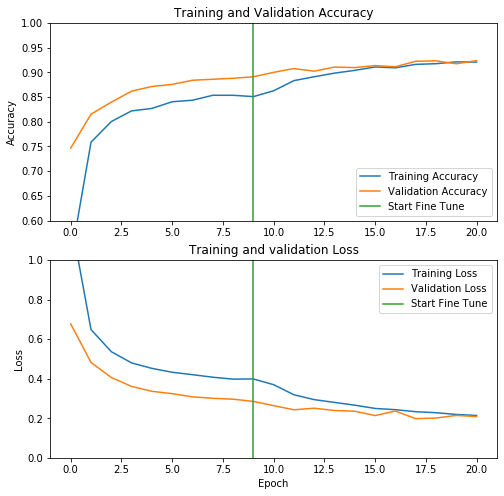

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(),
         label='Start Fine Tune')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1,], 
         plt.ylim(),
         label='Start Fine Tune')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and validation Loss')
plt.show()

## Evaluation and Prediction

In [35]:
loss, acc = model.evaluate(test_dataset)
print(f'Test Accuracy: {acc}')

6/6 [==============================] - 1s 114ms/step - loss: 0.0698 - accuracy: 0.9792
Test Accuracy: 0.9791666865348816


In [36]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print(f'Predictions: \n {predictions.numpy()}')
print(f'Labels: \n {label_batch}')

Predictions: 
 [0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0]
Labels: 
 [0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0]


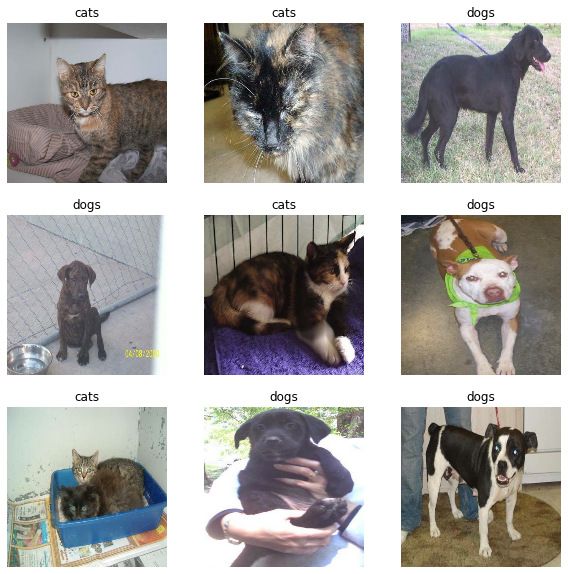

In [37]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])
    plt.axis('off')